In [1]:
# pip install --upgrade scikit-learn

In [2]:
import pandas as pd
import numpy as np
import re
import ast
import math
from typing import List, Dict, Any
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


# load csv file
df = pd.read_csv('merged_df.csv')

# print
df.head()

,job_link,job_title,company,skill,Title,Organization,course_url,Ratings,Duration
0,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,Google Digital Marketing & E-commerce,Google,https://www.coursera.org/professional-certific...,4.8,3 - 6 Months
1,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,IBM & Darden Digital Strategy,University of Virginia Darden School Foundation,https://www.coursera.org/specializations/digit...,4.7,3 - 6 Months
2,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,Meta Social Media Marketing,Meta,https://www.coursera.org/professional-certific...,4.8,3 - 6 Months
3,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,Business Strategy,University of Virginia,https://www.coursera.org/specializations/busin...,4.8,3 - 6 Months
4,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,"Influencing: Storytelling, Change Management a...",Macquarie University,https://www.coursera.org/specializations/influ...,4.8,3 - 6 Months


/tmp/ipython-input-3918332863.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_counts.values, y=job_counts.index, palette="Blues_r")


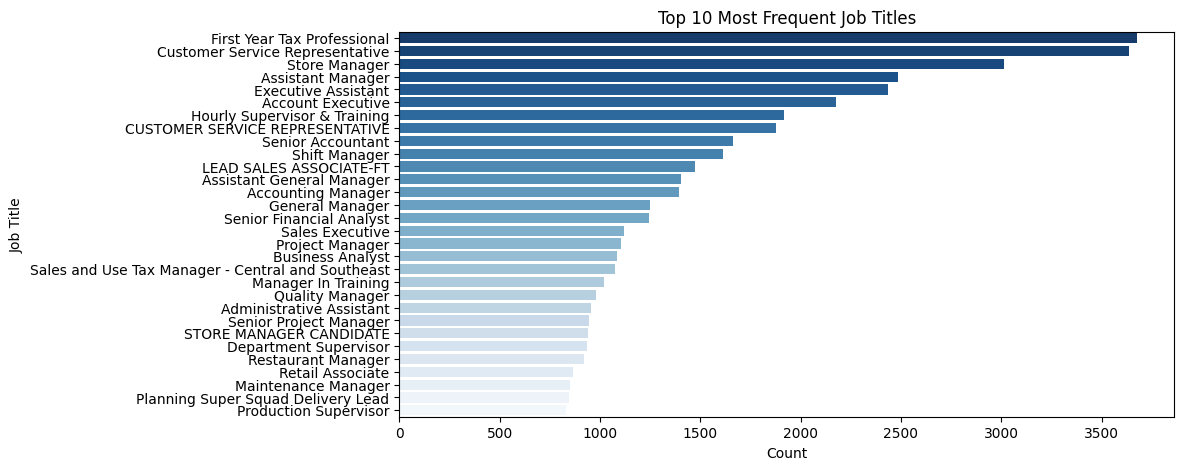

In [3]:
job_counts = df['job_title'].value_counts().head(30)

plt.figure(figsize=(10,5))
sns.barplot(x=job_counts.values, y=job_counts.index, palette="Blues_r")
plt.title("Top 10 Most Frequent Job Titles")
plt.xlabel("Count")
plt.ylabel("Job Title")
plt.show()

/tmp/ipython-input-2093921958.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=skill_df, palette='Greens_r')


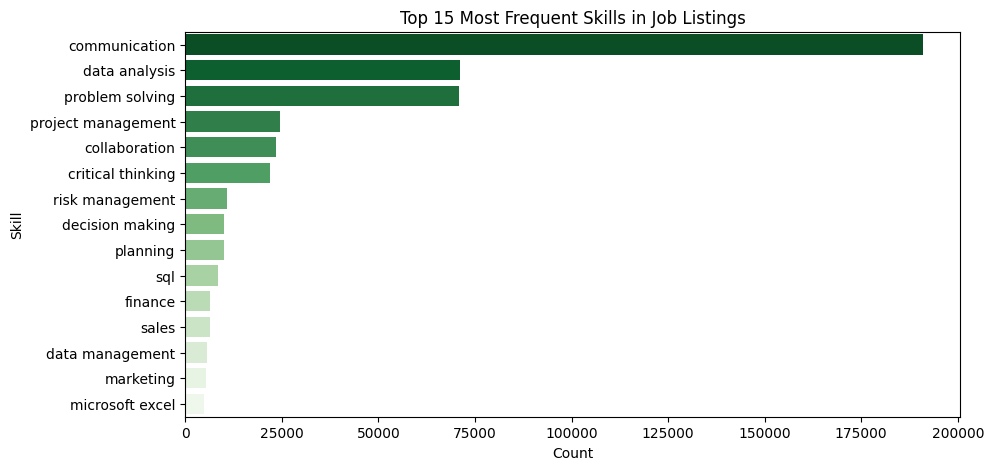

In [4]:
from collections import Counter
import re

# Separate skill column by comma and slash
skills_list = df['skill'].dropna().apply(lambda x: re.split(r'[,/;&]', str(x).lower()))
skills_flat = [s.strip() for sublist in skills_list for s in sublist if s.strip()]

# top 15 skill
skill_counts = Counter(skills_flat).most_common(15)

# DataFrame
skill_df = pd.DataFrame(skill_counts, columns=['Skill', 'Count'])

plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Skill', data=skill_df, palette='Greens_r')
plt.title("Top 15 Most Frequent Skills in Job Listings")
plt.xlabel("Count")
plt.ylabel("Skill")
plt.show()


In [5]:
# columns
COLS = {
    "job_link":     "job_link",
    "job_title":    "job_title",
    "company":      "company",
    "job_skill":    "skill",
    "course_title": "Title",
    "course_org":   "Organization",
    "course_url":   "course_url",
    "ratings":      "Ratings",
    "duration":     "Duration",
}

def normalize_text(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s).lower()
    s = re.sub(r"[/\-_|]", " ", s)
    s = re.sub(r"[^a-z0-9+.# ]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def split_skills(s: str):
    if pd.isna(s) or not str(s).strip(): return []
    s = normalize_text(str(s))
    toks = re.split(r"[,\;/&]+|\band\b", s)
    toks = [t.strip() for t in toks if t.strip()]
    norm = []
    for t in toks:
        t2 = (t.replace("node.js","nodejs")
               .replace("c++","cxx")
               .replace("c#","csharp")
               .replace("f#","fsharp"))
        t2 = re.sub(r"\bml\b","machine learning", t2)
        if len(t2) > 1: # remove 1 character token
          norm.append(t2)
    return list(dict.fromkeys(norm))

def duration_to_months(s: str):
    if pd.isna(s): return np.nan
    nums = re.findall(r"\d+\.?\d*", str(s).lower())
    if not nums: return np.nan
    vals = list(map(float, nums))
    return float(np.mean(vals)) if len(vals)>1 else vals[0]

def to_float_safe(x):
    try: return float(x)
    except: return np.nan

def extract_seniority(title: str) -> str:
    t = normalize_text(title)
    if re.search(r"\b(intern|entry|junior|jr)\b", t): return "junior"
    if re.search(r"\b(senior|sr|lead|principal)\b", t): return "senior"
    return "unspecified"

# create necessary columns
df["job_title_norm"]   = df[COLS["job_title"]].fillna("").map(normalize_text)
df["company_norm"]     = df[COLS["company"]].fillna("").map(normalize_text)
df["job_skills_set"]   = df[COLS["job_skill"]].fillna("").map(split_skills)
df["course_title_norm"]= df[COLS["course_title"]].fillna("").map(normalize_text)
df["course_org_norm"]  = df[COLS["course_org"]].fillna("").map(normalize_text)
df["course_skills_set"]= df["course_title_norm"].map(split_skills)
df["rating_float"]     = df[COLS["ratings"]].map(to_float_safe)
df["duration_months"]  = df[COLS["duration"]].map(duration_to_months)
df["seniority_hint"]   = df[COLS["job_title"]].fillna("").map(extract_seniority)

# TF-IDF input text
df["job_text"]    = (df["job_title_norm"] + " " + df["company_norm"] + " "
                     + df["job_skills_set"].apply(lambda xs: " ".join(xs))).str.strip()

df["course_text"] = (df["course_title_norm"] + " " + df["course_org_norm"] + " "
                     + df["course_skills_set"].apply(lambda xs: " ".join(xs))).str.strip()

df.to_csv('preprocessed_data.csv', index=False)


In [6]:
df_final= pd.read_csv('preprocessed_data.csv')

In [7]:
df_final

,job_link,job_title,company,skill,Title,Organization,course_url,Ratings,Duration,job_title_norm,company_norm,job_skills_set,course_title_norm,course_org_norm,course_skills_set,rating_float,duration_months,seniority_hint,job_text,course_text
0,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,Google Digital Marketing & E-commerce,Google,https://www.coursera.org/professional-certific...,4.8,3 - 6 Months,sales consultant,city club apartments,['sales'],google digital marketing e commerce,google,['google digital marketing e commerce'],4.8,4.5,unspecified,sales consultant city club apartments sales,google digital marketing e commerce google goo...
1,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,IBM & Darden Digital Strategy,University of Virginia Darden School Foundation,https://www.coursera.org/specializations/digit...,4.7,3 - 6 Months,sales consultant,city club apartments,['sales'],ibm darden digital strategy,university of virginia darden school foundation,['ibm darden digital strategy'],4.7,4.5,unspecified,sales consultant city club apartments sales,ibm darden digital strategy university of virg...
2,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,Meta Social Media Marketing,Meta,https://www.coursera.org/professional-certific...,4.8,3 - 6 Months,sales consultant,city club apartments,['sales'],meta social media marketing,meta,['meta social media marketing'],4.8,4.5,unspecified,sales consultant city club apartments sales,meta social media marketing meta meta social m...
3,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,Business Strategy,University of Virginia,https://www.coursera.org/specializations/busin...,4.8,3 - 6 Months,sales consultant,city club apartments,['sales'],business strategy,university of virginia,['business strategy'],4.8,4.5,unspecified,sales consultant city club apartments sales,business strategy university of virginia busin...
4,https://www.linkedin.com/jobs/view/sales-consu...,Sales Consultant,City Club Apartments,sales,"Influencing: Storytelling, Change Management a...",Macquarie University,https://www.coursera.org/specializations/influ...,4.8,3 - 6 Months,sales consultant,city club apartments,['sales'],influencing storytelling change management and...,macquarie university,"['influencing storytelling change management',...",4.8,4.5,unspecified,sales consultant city club apartments sales,influencing storytelling change management and...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562296,https://ca.linkedin.com/jobs/view/payroll-anal...,Payroll Analyst (6 month contract),CloudMD (TSXV:DOC),data analysis,Google Project Management,Google,https://www.coursera.org/professional-certific...,4.6,3 - 6 Months,payroll analyst 6 month contract,cloudmd tsxv doc,['data analysis'],google project management,google,['google project management'],4.6,4.5,unspecified,payroll analyst 6 month contract cloudmd tsxv ...,google project management google google projec...
562297,https://ca.linkedin.com/jobs/view/payroll-anal...,Payroll Analyst (6 month contract),CloudMD (TSXV:DOC),data analysis,Data Analysis with R Programming,Google,https://www.coursera.org/learn/data-analysis-r,4.8,1 - 3 Months,payroll analyst 6 month contract,cloudmd tsxv doc,['data analysis'],data analysis with r programming,google,['data analysis with r programming'],4.8,2.0,unspecified,payroll analyst 6 month contract cloudmd tsxv ...,data analysis with r programming google data a...
562298,https://ca.linkedin.com/jobs/view/payroll-anal...,Payroll Analyst (6 month contract),CloudMD (TSXV:DOC),data analysis,Excel Basics for Data Analysis,IBM,https://www.coursera.org/learn/excel-basics-da...,4.8,1 - 3 Months,payroll analyst 6 month contract,cloudmd tsxv doc,['data analysis'],excel basics for data analysis,ibm,['excel basics for data analysis'],4.8

In [8]:
# Create nomarlized view jobs/courses/edges


df = pd.read_csv("preprocessed_data.csv")

def keyify(s: str) -> str:
    s = "" if pd.isna(s) else str(s).lower().strip()
    return re.sub(r"\s+", " ", s)

# unique key (prevent from duplication, bias)
df["job_key"]    = df["job_title_norm"].map(keyify) + " | " + df["company_norm"].map(keyify)
df["course_key"] = df["course_title_norm"].map(keyify) + " | " + df["course_org_norm"].map(keyify)

# jobs view (1 Job by 1 row )
jobs = (df[[
    "job_key",
    COLS["job_link"], COLS["job_title"], COLS["company"],
    "job_skills_set", "job_text", "seniority_hint"
]]
    .drop_duplicates("job_key")
    .rename(columns={
        COLS["job_link"]:"job_link",
        COLS["job_title"]:"job_title",
        COLS["company"]:"company",
    })
    .reset_index(drop=True)
)

# courses view (1 Course by 1 row)
courses = (df[[
    "course_key",
    COLS["course_title"], COLS["course_org"], COLS["course_url"],
    "rating_float", "duration_months", "course_skills_set", "course_text"
]]
    .drop_duplicates("course_key")
    .rename(columns={
        COLS["course_title"]:"course_title",
        COLS["course_org"]:"course_org",
        COLS["course_url"]:"course_url",
    })
    .reset_index(drop=True)
)

# edge view: from original merged table, pick job_key and course_key. Links that co-occured in the same row
edges = df[["job_key","course_key"]].dropna().drop_duplicates().reset_index(drop=True)

print("jobs:", jobs.shape, "courses:", courses.shape, "edges:", edges.shape)


jobs: (4347, 7) courses: (583, 8) edges: (430365, 2)


In [9]:
# Embedding Training :TF-IDF(optional LSA/SVD)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

# Hyperparameter
JOB_MAX_FEATURES    = 30000
COURSE_MAX_FEATURES = 30000
EMBED_DIM           = 256
USE_LSA             = True

# Job Embeddings
job_tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=JOB_MAX_FEATURES, dtype=np.float32)
X_job_tfidf = job_tfidf.fit_transform(jobs["job_text"])

if USE_LSA:
    job_svd  = TruncatedSVD(n_components=EMBED_DIM, random_state=42)
    job_norm = Normalizer(copy=False)
    job_pipe = make_pipeline(job_svd, job_norm)
    X_job = job_pipe.fit_transform(X_job_tfidf)
else:
    job_pipe = None
    X_job = X_job_tfidf

print("Job vocab:", len(job_tfidf.vocabulary_), "| X_job shape:", X_job.shape)

# Course Embeddings (TF-IDF → optional LSA with dynamic dimension)

# Vectorize course_text
course_tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_features=COURSE_MAX_FEATURES,
    dtype=np.float32
)
X_course_tfidf = course_tfidf.fit_transform(courses["course_text"])

# Use LSA
if USE_LSA:
    n_features_course = X_course_tfidf.shape[1]
    n_samples_course  = X_course_tfidf.shape[0]

    # SVD requires: n_components <= min(n_features, n_samples) - 1 (practical safe rule)
    course_dim = min(EMBED_DIM, n_features_course - 1, n_samples_course - 1)

    if course_dim >= 2:
        # Build SVD ->  L2 normalize pipeline
        course_svd  = TruncatedSVD(n_components=course_dim, random_state=42)
        course_norm = Normalizer(copy=False)
        course_pipe = make_pipeline(course_svd, course_norm)

        # Fit LSA on TF-IDF and transform to dense, low-dimensional semantic vectors
        X_course = course_pipe.fit_transform(X_course_tfidf)
        print(f"[COURSE] LSA enabled. dim={course_dim} (features={n_features_course}, samples={n_samples_course})")
    else:
        # If too few features/samples, skip LSA and use raw TF-IDF
        course_pipe = None
        X_course    = X_course_tfidf
        print("[COURSE] LSA skipped (too few features/samples). Using raw TF-IDF vectors.")
else:
    # If LSA is globally disabled, use raw TF-IDF
    course_pipe = None
    X_course    = X_course_tfidf
    print("[COURSE] Using raw TF-IDF (LSA disabled).")


print("Course vocab:", len(course_tfidf.vocabulary_), "| X_course shape:", X_course.shape)


Job vocab: 1621 | X_job shape: (4347, 256)
[COURSE] LSA enabled. dim=250 (features=251, samples=583)
Course vocab: 251 | X_course shape: (583, 250)
